In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../')
from utils import quant
from utils import symbols

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import yfinance as yf
import ta
from neurodsp import sim #for brownian motion 
from math import log, floor

In [23]:
tsla = yf.download('TSLA', '2019-01-01','2020-01-01')
data = np.array(tsla['Close'])
df = symbols.df

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  



[*********************100%***********************]  1 of 1 completed


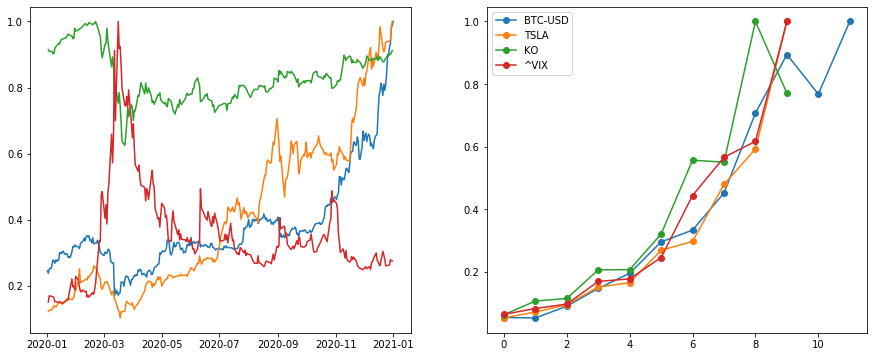

In [31]:
plt.figure(figsize=(15,6))
for tk in ('BTC-USD','TSLA','KO','^VIX'):
    stk = yf.download(tk, '2020-01-01','2021-01-01')['Close']
    plt.subplot(1,2,1)
    plt.plot(stk/max(stk))
    plt.subplot(1,2,2)    
    a,flux = quant.dfa(np.array(stk))
    plt.plot(flux/max(flux),'o-',label=tk)
plt.legend()

## Simulating fBm based on DFA params (alpha)

Text(0.5, 1.0, 'fbm with $\\alpha$ = 1.53')

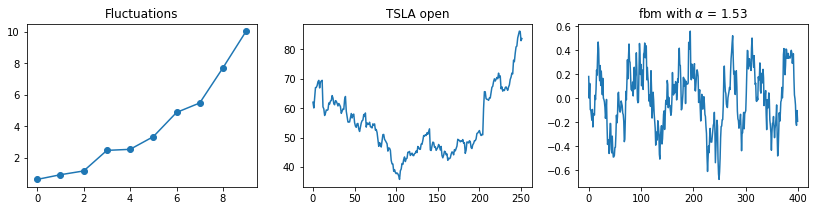

In [25]:
alpha, flux = quant.dfa(data)
fbm = []
for i in range(20):
    fbm.append(sim.sim_powerlaw(n_seconds=20, fs=20, f_range = [0.1, 9], exponent=-1.5)) #really need to make own fbm
    
avg_fbm = np.array(fbm).mean(0)

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(flux, 'o-'); plt.title('Fluctuations')
plt.subplot(1,3,2)
plt.plot(data); plt.title('TSLA open')
plt.subplot(1,3,3)
plt.plot(avg_fbm); plt.title('fbm with '+ r'$\alpha$ = '+str(round(alpha,2)))

So we see some sort of nonlinearity as well as possibly different time scales.

Maybe DFA needs to be restricted to certain epochs (e.g. volatile vs bull vs bear).  How do we delineate between them? 

As a starting point, can separate epochs based on derivative of moving average.
- Based on the below plot, should create epochs > x% of the gradients are of a different sign than the last one (so that 1 different sign does not create a different epoch)
    - x = 10/252 = 4% based on the gradient plot below
- later can do when the derivative deviates a certain amount


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.gradient(mavg20), '.-')
plt.axhline(y=0, color='r')
plt.title('Gradients for mavg20')

In [ ]:
def create_epochs(data, mavg_len, min_pct = .05):
    """Separates time series into epochs based on moving average activity
    mavg is currently computed from ta library """
    mavg = ta.volatility.bollinger_mavg(data, mavg_len)
    min_epoch = int(min_pct*mavg.shape[0])
    gradients = np.gradient(mavg)
    epoch_indices = []

    sign_count = 0 #counts the consecutive number of a sign once the sign changes 
    encounter = 0
    for n_i, i in enumerate(gradients):     
        if n_i > 0:
            if past_sign != i**0:
                sign_count = 0
            else:
                sign_count +=1
                
        if sign_count >= min_epoch:
            epoch_indices.append(n_i)
        
        past_sign = i**0 #Sign to use in next iter; either -1 or 1
        
    return epoch_indices

In [ ]:
epoch_i = create_epochs(tsla['Open'], mavg_len = 20)
plt.plot(epoch_i, 'o')